In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import scipy
import scipy.interpolate
from scipy.special import erf
import matplotlib.pyplot as plt
import sys

locale = r"C:\Users\Fredric\Documents\Volcano\quail_volcano\src\compressible_conduit_steady"
import os
os.chdir(locale)
import steady_state
os.chdir(r"C:\Users\Fredric\Documents\Volcano\compressible-conduit-lowM")
from lowM_split import SplitSolver

x_km_range = np.linspace(0, 15000, 100)
f = steady_state.SteadyState(x_km_range, 1e5, 100e6, input_type="p",
                             override_properties={
                               "tau_f": 1e0, # 1e-2,
                               "tau_d": 3e0, # 1e-2,
                              #  "yWt": 0.05,
                               "yC": 0.4,
                               "rho0_magma": 2.6e3,
                             }, skip_rootfinding=True)

In [3]:
def loc_F_fric_viscosity_model(T, y, yF, yWt=0.03, yC=0.4):
  ''' Calculates the viscosity as a function of dissolved
  water and crystal content (assumes crystal phase is incompressible)/
  Does not take into account fragmented vs. not fragmented (avoiding
  double-dipping the effect of fragmentation).
  '''
  # Calculate pure melt viscosity (Hess & Dingwell 1996)
  yWd = yWt - y
  yM = 1.0 - y
  yL = yM - (yWd + yC)
  mfWd = yWd / yL # mass concentration of dissolved water
  mfWd = np.where(mfWd <= 0.0, 1e-8, mfWd)
  log_mfWd = np.log(mfWd*100)
  log10_vis = -3.545 + 0.833 * log_mfWd
  log10_vis += (9601 - 2368 * log_mfWd) / (T - 195.7 - 32.25 * log_mfWd)
  # Prevent overflowing float
  log10_vis = np.where(log10_vis > 300, 300, log10_vis)
  meltVisc = 10**log10_vis
  # Calculate relative viscosity due to crystals (Costa 2005).
  alpha = 0.999916
  phi_cr = 0.673
  gamma = 3.98937
  delta = 16.9386
  B = 2.5
  # Compute volume fraction of crystal at equal phasic densities
  # Using crystal volume per (melt + crystal + dissolved water) volume
  phi_ratio = np.clip((yC / yM) / phi_cr, 0.0, None)
  erf_term = erf(
    np.sqrt(np.pi) / (2 * alpha) * phi_ratio * (1 + phi_ratio**gamma))
  crysVisc = (1 + phi_ratio**delta) * ((1 - alpha * erf_term)**(-B * phi_cr))
  
  viscosity = meltVisc * crysVisc
  return viscosity
  
params = {
    "T0": 1050,
    "conduit_radius": 50,
    "tau_d": 10.0, # CHECK, and Euler stability
    "tau_f": 1.0, # TODO: add resonant case for tau_f == tau_d
    "vf_g_crit": 0.75,
    "solubility_n": 0.5,
    "solubility_k": 5e-06,
    "K": 10e9,
    "rho_m0": 2.6e3,
    "p_m0": 36e6,
    "R_wv": f.mixture.waterEx.R,
    "F_fric_viscosity_model": loc_F_fric_viscosity_model,
  }


### Convergence comparison

In [10]:
# Load
from types import SimpleNamespace
def loadToNamespace(file_radix:str) -> SimpleNamespace:
  q2 = np.load(f"{file_radix}_q2.npy")
  q5 = np.load(f"{file_radix}_q5.npy")
  t = np.load(f"{file_radix}_t.npy")
  x = np.load(f"{file_radix}_x.npy")

  # Unpack pressure, velocity
  p = q2[:,0,:]
  u = q2[:,1,:]
  # Unpack mass fractions (index [:,0,:] is blank for future implementation)
  yWv = q5[:,1,:]
  yWt = q5[:,2,:]
  yC  = q5[:,3,:]
  yF  = q5[:,4,:]

  return SimpleNamespace(q2=q2,
                         q5=q5,
                         t=t,
                         x=x,
                         p=p,
                         u=u,
                         yWv=yWv,
                         yWt=yWt,
                         yC=yC,
                         yF=yF,
  )


#### New self-convergence test

In [29]:
''' Run QSS solver with choked flow '''
# Set total crystal mass fraction
yC0 = 0.4
# Set total water mass fraction
yWt0 = 0.03 * (1.0 - yC0) / (1.0 + 0.03)
# Define solver, with number of timesteps to run for
split_solver = SplitSolver(params, Nt=800)
# Set desired courant number to set the timestep (>1 is OK)
courant = 32
# Set desired chamber pressure
p0 = 40e6
q_pu, q_t = split_solver.full_solve_choked((0,1000), Nx=3201, p0=p0, yWt0=yWt0,
                yC0=yC0, CFL=courant, ivp_method="RK45", ivp_max_step=np.inf,
                t0=50, sigma=10)
print(f"Final t: {split_solver.t} s")

# Refinement level
ref_lvl = 0
np.save(f"SBC_verification_ow{ref_lvl}_q2", split_solver.out_q2)
np.save(f"SBC_verification_ow{ref_lvl}_q5", split_solver.out_q5)
np.save(f"SBC_verification_ow{ref_lvl}_t", split_solver.out_t)
np.save(f"SBC_verification_ow{ref_lvl}_x", split_solver.x)

DEBUG:lowM_split_2024-07-10T181704:Steady state brentq called.
DEBUG:lowM_split_2024-07-10T181704:Steady state brentq call results:       converged: True
           flag: 'converged'
 function_calls: 26
     iterations: 25
           root: 1.0939611345800406
DEBUG:lowM_split_2024-07-10T181704:Steady state solve called with u0 = 1.0939611345800406
DEBUG:lowM_split_2024-07-10T181704:Timestep loop entered with with dt = 0.12182597344822983.
DEBUG:lowM_split_2024-07-10T181704:Setup time was 7.063358600000356.
DEBUG:lowM_split_2024-07-10T181704:q5 L2-norm:                    [ 0.          0.27417583  0.55263105 12.64911064 20.85696719]
DEBUG:lowM_split_2024-07-10T181704:q5 L2-norm updated           : [ 0.          0.27417582  0.55263105 12.64911064 20.85696875]
DEBUG:lowM_split_2024-07-10T181704:Clip stage: is q5 == np.clip: False
DEBUG:lowM_split_2024-07-10T181704:Inlet velocity atol 1.00e-04 reached in Newton step 1
DEBUG:lowM_split_2024-07-10T181704:Solved step 0 (t = 0.00000 s) in 0.279

Final t: 97.33895278513563 s


In [30]:
''' Run QSS solver with choked flow '''
# Set total crystal mass fraction
yC0 = 0.4
# Set total water mass fraction
yWt0 = 0.03 * (1.0 - yC0) / (1.0 + 0.03)
# Define solver, with number of timesteps to run for
split_solver = SplitSolver(params, Nt=400)
# Set desired courant number to set the timestep (>1 is OK)
courant = 64
# Set desired chamber pressure
p0 = 40e6
q_pu, q_t = split_solver.full_solve_choked((0,1000), Nx=3201, p0=p0, yWt0=yWt0,
                yC0=yC0, CFL=courant, ivp_method="RK45", ivp_max_step=np.inf,
                t0=50, sigma=10)
print(f"Final t: {split_solver.t} s")

# Refinement level
ref_lvl = "00"
np.save(f"SBC_verification_ow{ref_lvl}_q2", split_solver.out_q2)
np.save(f"SBC_verification_ow{ref_lvl}_q5", split_solver.out_q5)
np.save(f"SBC_verification_ow{ref_lvl}_t", split_solver.out_t)
np.save(f"SBC_verification_ow{ref_lvl}_x", split_solver.x)

DEBUG:lowM_split_2024-07-10T182051:Steady state brentq called.
DEBUG:lowM_split_2024-07-10T182051:Steady state brentq call results:       converged: True
           flag: 'converged'
 function_calls: 26
     iterations: 25
           root: 1.0939611345800406
DEBUG:lowM_split_2024-07-10T182051:Steady state solve called with u0 = 1.0939611345800406
DEBUG:lowM_split_2024-07-10T182051:Timestep loop entered with with dt = 0.24365194689645966.
DEBUG:lowM_split_2024-07-10T182051:Setup time was 6.903485400000136.
DEBUG:lowM_split_2024-07-10T182051:q5 L2-norm:                    [ 0.          0.27417583  0.55263105 12.64911064 20.85696719]
DEBUG:lowM_split_2024-07-10T182051:q5 L2-norm updated           : [ 0.          0.27417582  0.55263105 12.64911064 20.85696873]
DEBUG:lowM_split_2024-07-10T182051:Clip stage: is q5 == np.clip: False
DEBUG:lowM_split_2024-07-10T182051:Inlet velocity atol 1.00e-04 reached in Newton step 1
DEBUG:lowM_split_2024-07-10T182051:Solved step 0 (t = 0.00000 s) in 0.262

Final t: 97.21712681168741 s


In [31]:
''' Run QSS solver with choked flow '''
# Set total crystal mass fraction
yC0 = 0.4
# Set total water mass fraction
yWt0 = 0.03 * (1.0 - yC0) / (1.0 + 0.03)
# Define solver, with number of timesteps to run for
split_solver = SplitSolver(params, Nt=200)
# Set desired courant number to set the timestep (>1 is OK)
courant = 128
# Set desired chamber pressure
p0 = 40e6
q_pu, q_t = split_solver.full_solve_choked((0,1000), Nx=3201, p0=p0, yWt0=yWt0,
                yC0=yC0, CFL=courant, ivp_method="RK45", ivp_max_step=np.inf,
                t0=50, sigma=10)
print(f"Final t: {split_solver.t} s")

# Refinement level
ref_lvl = "000"
np.save(f"SBC_verification_ow{ref_lvl}_q2", split_solver.out_q2)
np.save(f"SBC_verification_ow{ref_lvl}_q5", split_solver.out_q5)
np.save(f"SBC_verification_ow{ref_lvl}_t", split_solver.out_t)
np.save(f"SBC_verification_ow{ref_lvl}_x", split_solver.x)

DEBUG:lowM_split_2024-07-10T182246:Steady state brentq called.
DEBUG:lowM_split_2024-07-10T182246:Steady state brentq call results:       converged: True
           flag: 'converged'
 function_calls: 26
     iterations: 25
           root: 1.0939611345800406
DEBUG:lowM_split_2024-07-10T182246:Steady state solve called with u0 = 1.0939611345800406
DEBUG:lowM_split_2024-07-10T182246:Timestep loop entered with with dt = 0.48730389379291933.
DEBUG:lowM_split_2024-07-10T182246:Setup time was 6.8203384000007645.
DEBUG:lowM_split_2024-07-10T182246:q5 L2-norm:                    [ 0.          0.27417583  0.55263105 12.64911064 20.85696719]
DEBUG:lowM_split_2024-07-10T182246:q5 L2-norm updated           : [ 0.          0.27417582  0.55263105 12.64911065 20.85694449]
DEBUG:lowM_split_2024-07-10T182246:Clip stage: is q5 == np.clip: False
DEBUG:lowM_split_2024-07-10T182246:Inlet velocity atol 1.00e-04 reached in Newton step 1
DEBUG:lowM_split_2024-07-10T182246:Solved step 0 (t = 0.00000 s) in 0.25

Final t: 96.97347486479094 s


In [32]:
''' Run QSS solver with choked flow '''
# Set total crystal mass fraction
yC0 = 0.4
# Set total water mass fraction
yWt0 = 0.03 * (1.0 - yC0) / (1.0 + 0.03)
# Define solver, with number of timesteps to run for
split_solver = SplitSolver(params, Nt=100)
# Set desired courant number to set the timestep (>1 is OK)
courant = 256
# Set desired chamber pressure
p0 = 40e6
q_pu, q_t = split_solver.full_solve_choked((0,1000), Nx=3201, p0=p0, yWt0=yWt0,
                yC0=yC0, CFL=courant, ivp_method="RK45", ivp_max_step=np.inf,
                t0=50, sigma=10)
print(f"Final t: {split_solver.t} s")

# Refinement level
ref_lvl = "0000"
np.save(f"SBC_verification_ow{ref_lvl}_q2", split_solver.out_q2)
np.save(f"SBC_verification_ow{ref_lvl}_q5", split_solver.out_q5)
np.save(f"SBC_verification_ow{ref_lvl}_t", split_solver.out_t)
np.save(f"SBC_verification_ow{ref_lvl}_x", split_solver.x)

DEBUG:lowM_split_2024-07-10T182351:Steady state brentq called.
DEBUG:lowM_split_2024-07-10T182351:Steady state brentq call results:       converged: True
           flag: 'converged'
 function_calls: 26
     iterations: 25
           root: 1.0939611345800406
DEBUG:lowM_split_2024-07-10T182351:Steady state solve called with u0 = 1.0939611345800406
DEBUG:lowM_split_2024-07-10T182351:Timestep loop entered with with dt = 0.9746077875858387.
DEBUG:lowM_split_2024-07-10T182351:Setup time was 6.876473300000725.
DEBUG:lowM_split_2024-07-10T182351:q5 L2-norm:                    [ 0.          0.27417583  0.55263105 12.64911064 20.85696719]
DEBUG:lowM_split_2024-07-10T182351:q5 L2-norm updated           : [ 0.          0.27417585  0.55263105 12.64911066 20.85600135]
DEBUG:lowM_split_2024-07-10T182351:Clip stage: is q5 == np.clip: False
DEBUG:lowM_split_2024-07-10T182351:Residual increased at Newton step 2
DEBUG:lowM_split_2024-07-10T182351:Solved step 0 (t = 0.00000 s) in 0.3669559999998455 s.
DE

Final t: 96.48617097099803 s


In [44]:
''' Run QSS solver with choked flow '''
# Set total crystal mass fraction
yC0 = 0.4
# Set total water mass fraction
yWt0 = 0.03 * (1.0 - yC0) / (1.0 + 0.03)
# Define solver, with number of timesteps to run for
split_solver = SplitSolver(params, Nt=50)
# Set desired courant number to set the timestep (>1 is OK)
courant = 512
# Set desired chamber pressure
p0 = 40e6
q_pu, q_t = split_solver.full_solve_choked((0,1000), Nx=3201, p0=p0, yWt0=yWt0,
                yC0=yC0, CFL=courant, ivp_method="RK45", ivp_max_step=np.inf,
                t0=50, sigma=10)
print(f"Final t: {split_solver.t} s")

# Refinement level
ref_lvl = "0x5"
np.save(f"SBC_verification_ow{ref_lvl}_q2", split_solver.out_q2)
np.save(f"SBC_verification_ow{ref_lvl}_q5", split_solver.out_q5)
np.save(f"SBC_verification_ow{ref_lvl}_t", split_solver.out_t)
np.save(f"SBC_verification_ow{ref_lvl}_x", split_solver.x)

DEBUG:lowM_split_2024-07-10T205528:Steady state brentq called.
DEBUG:lowM_split_2024-07-10T205528:Steady state brentq call results:       converged: True
           flag: 'converged'
 function_calls: 26
     iterations: 25
           root: 1.0939611345800406
DEBUG:lowM_split_2024-07-10T205528:Steady state solve called with u0 = 1.0939611345800406
DEBUG:lowM_split_2024-07-10T205528:Timestep loop entered with with dt = 1.9492155751716773.
DEBUG:lowM_split_2024-07-10T205528:Setup time was 6.534123000001273.
DEBUG:lowM_split_2024-07-10T205528:q5 L2-norm:                    [ 0.          0.27417583  0.55263105 12.64911064 20.85696719]
DEBUG:lowM_split_2024-07-10T205528:q5 L2-norm updated           : [ 0.          0.27417622  0.55263105 12.64911068 20.82378231]
DEBUG:lowM_split_2024-07-10T205528:Clip stage: is q5 == np.clip: False
DEBUG:lowM_split_2024-07-10T205528:Inlet velocity atol 1.00e-04 reached in Newton step 3
DEBUG:lowM_split_2024-07-10T205528:Solved step 0 (t = 0.00000 s) in 0.4974

Final t: 95.51156318341219 s


In [65]:
''' Run QSS solver with choked flow '''
# Set total crystal mass fraction
yC0 = 0.4
# Set total water mass fraction
yWt0 = 0.03 * (1.0 - yC0) / (1.0 + 0.03)
# Define solver, with number of timesteps to run for
split_solver = SplitSolver(params, Nt=70)
# Set desired courant number to set the timestep (>1 is OK)
courant = 512*5/7
# Set desired chamber pressure
p0 = 40e6
q_pu, q_t = split_solver.full_solve_choked((0,1000), Nx=3201, p0=p0, yWt0=yWt0,
                yC0=yC0, CFL=courant, ivp_method="RK45", ivp_max_step=np.inf,
                t0=50, sigma=10)
print(f"Final t: {split_solver.t} s")

# Refinement level
ref_lvl = "0x55"
np.save(f"SBC_verification_ow{ref_lvl}_q2", split_solver.out_q2)
np.save(f"SBC_verification_ow{ref_lvl}_q5", split_solver.out_q5)
np.save(f"SBC_verification_ow{ref_lvl}_t", split_solver.out_t)
np.save(f"SBC_verification_ow{ref_lvl}_x", split_solver.x)

DEBUG:lowM_split_2024-07-10T211149:Steady state brentq called.
DEBUG:lowM_split_2024-07-10T211149:Steady state brentq call results:       converged: True
           flag: 'converged'
 function_calls: 26
     iterations: 25
           root: 1.0939611345800406
DEBUG:lowM_split_2024-07-10T211149:Steady state solve called with u0 = 1.0939611345800406
DEBUG:lowM_split_2024-07-10T211149:Timestep loop entered with with dt = 1.392296839408341.
DEBUG:lowM_split_2024-07-10T211149:Setup time was 6.5101066999995965.
DEBUG:lowM_split_2024-07-10T211149:q5 L2-norm:                    [ 0.          0.27417583  0.55263105 12.64911064 20.85696719]
DEBUG:lowM_split_2024-07-10T211149:q5 L2-norm updated           : [ 0.          0.27417594  0.55263105 12.64911067 20.85087826]
DEBUG:lowM_split_2024-07-10T211149:Clip stage: is q5 == np.clip: False
DEBUG:lowM_split_2024-07-10T211149:Inlet velocity atol 1.00e-04 reached in Newton step 2
DEBUG:lowM_split_2024-07-10T211149:Solved step 0 (t = 0.00000 s) in 0.3668

Final t: 96.06848191917553 s


In [33]:
''' Run QSS solver with choked flow '''
# Set total crystal mass fraction
yC0 = 0.4
# Set total water mass fraction
yWt0 = 0.03 * (1.0 - yC0) / (1.0 + 0.03)
# Define solver, with number of timesteps to run for
split_solver = SplitSolver(params, Nt=1600)
# Set desired courant number to set the timestep (>1 is OK)
courant = 16
# Set desired chamber pressure
p0 = 40e6
q_pu, q_t = split_solver.full_solve_choked((0,1000), Nx=3201, p0=p0, yWt0=yWt0,
                yC0=yC0, CFL=courant, ivp_method="RK45", ivp_max_step=np.inf,
                t0=50, sigma=10)
print(f"Final t: {split_solver.t} s")

# Refinement level
ref_lvl = "1"
np.save(f"SBC_verification_ow{ref_lvl}_q2", split_solver.out_q2)
np.save(f"SBC_verification_ow{ref_lvl}_q5", split_solver.out_q5)
np.save(f"SBC_verification_ow{ref_lvl}_t", split_solver.out_t)
np.save(f"SBC_verification_ow{ref_lvl}_x", split_solver.x)

DEBUG:lowM_split_2024-07-10T182437:Steady state brentq called.
DEBUG:lowM_split_2024-07-10T182437:Steady state brentq call results:       converged: True
           flag: 'converged'
 function_calls: 26
     iterations: 25
           root: 1.0939611345800406
DEBUG:lowM_split_2024-07-10T182437:Steady state solve called with u0 = 1.0939611345800406
DEBUG:lowM_split_2024-07-10T182437:Timestep loop entered with with dt = 0.060912986724114916.
DEBUG:lowM_split_2024-07-10T182437:Setup time was 6.886921299999813.
DEBUG:lowM_split_2024-07-10T182437:q5 L2-norm:                    [ 0.          0.27417583  0.55263105 12.64911064 20.85696719]
DEBUG:lowM_split_2024-07-10T182437:q5 L2-norm updated           : [ 0.          0.27417583  0.55263105 12.64911064 20.85696688]
DEBUG:lowM_split_2024-07-10T182437:Clip stage: is q5 == np.clip: False
DEBUG:lowM_split_2024-07-10T182437:Inlet velocity atol 1.00e-04 reached in Newton step 1
DEBUG:lowM_split_2024-07-10T182437:Solved step 0 (t = 0.00000 s) in 0.25

Final t: 97.39986577185975 s


In [34]:
''' Run QSS solver with choked flow '''
# Set total crystal mass fraction
yC0 = 0.4
# Set total water mass fraction
yWt0 = 0.03 * (1.0 - yC0) / (1.0 + 0.03)
# Define solver, with number of timesteps to run for
split_solver = SplitSolver(params, Nt=3200)
# Set desired courant number to set the timestep (>1 is OK)
courant = 8
# Set desired chamber pressure
p0 = 40e6
q_pu, q_t = split_solver.full_solve_choked((0,1000), Nx=3201, p0=p0, yWt0=yWt0,
                yC0=yC0, CFL=courant, ivp_method="RK45", ivp_max_step=np.inf,
                t0=50, sigma=10)
print(f"Final t: {split_solver.t} s")

# Refinement level
ref_lvl = "2"
np.save(f"SBC_verification_ow{ref_lvl}_q2", split_solver.out_q2)
np.save(f"SBC_verification_ow{ref_lvl}_q5", split_solver.out_q5)
np.save(f"SBC_verification_ow{ref_lvl}_t", split_solver.out_t)
np.save(f"SBC_verification_ow{ref_lvl}_x", split_solver.x)

DEBUG:lowM_split_2024-07-10T183140:Steady state brentq called.
DEBUG:lowM_split_2024-07-10T183140:Steady state brentq call results:       converged: True
           flag: 'converged'
 function_calls: 26
     iterations: 25
           root: 1.0939611345800406
DEBUG:lowM_split_2024-07-10T183140:Steady state solve called with u0 = 1.0939611345800406
DEBUG:lowM_split_2024-07-10T183140:Timestep loop entered with with dt = 0.030456493362057458.
DEBUG:lowM_split_2024-07-10T183140:Setup time was 6.979562100001203.
DEBUG:lowM_split_2024-07-10T183140:q5 L2-norm:                    [ 0.          0.27417583  0.55263105 12.64911064 20.85696719]
DEBUG:lowM_split_2024-07-10T183140:q5 L2-norm updated           : [ 0.          0.27417583  0.55263105 12.64911064 20.85696803]
DEBUG:lowM_split_2024-07-10T183140:Clip stage: is q5 == np.clip: False
DEBUG:lowM_split_2024-07-10T183140:Inlet velocity atol 1.00e-04 reached in Newton step 1
DEBUG:lowM_split_2024-07-10T183140:Solved step 0 (t = 0.00000 s) in 0.26

Final t: 97.4303222652218 s


In [35]:
''' Run QSS solver with choked flow '''
# Set total crystal mass fraction
yC0 = 0.4
# Set total water mass fraction
yWt0 = 0.03 * (1.0 - yC0) / (1.0 + 0.03)
# Define solver, with number of timesteps to run for
split_solver = SplitSolver(params, Nt=6400)
# Set desired courant number to set the timestep (>1 is OK)
courant = 4
# Set desired chamber pressure
p0 = 40e6
q_pu, q_t = split_solver.full_solve_choked((0,1000), Nx=3201, p0=p0, yWt0=yWt0,
                yC0=yC0, CFL=courant, ivp_method="RK45", ivp_max_step=np.inf,
                t0=50, sigma=10)
print(f"Final t: {split_solver.t} s")

# Refinement level
ref_lvl = "3"
np.save(f"SBC_verification_ow{ref_lvl}_q2", split_solver.out_q2)
np.save(f"SBC_verification_ow{ref_lvl}_q5", split_solver.out_q5)
np.save(f"SBC_verification_ow{ref_lvl}_t", split_solver.out_t)
np.save(f"SBC_verification_ow{ref_lvl}_x", split_solver.x)

DEBUG:lowM_split_2024-07-10T184521:Steady state brentq called.
DEBUG:lowM_split_2024-07-10T184521:Steady state brentq call results:       converged: True
           flag: 'converged'
 function_calls: 26
     iterations: 25
           root: 1.0939611345800406
DEBUG:lowM_split_2024-07-10T184521:Steady state solve called with u0 = 1.0939611345800406
DEBUG:lowM_split_2024-07-10T184521:Timestep loop entered with with dt = 0.015228246681028729.
DEBUG:lowM_split_2024-07-10T184521:Setup time was 6.948082799999611.
DEBUG:lowM_split_2024-07-10T184521:q5 L2-norm:                    [ 0.          0.27417583  0.55263105 12.64911064 20.85696719]
DEBUG:lowM_split_2024-07-10T184521:q5 L2-norm updated           : [ 0.          0.27417583  0.55263105 12.64911064 20.85696832]
DEBUG:lowM_split_2024-07-10T184521:Clip stage: is q5 == np.clip: False
DEBUG:lowM_split_2024-07-10T184521:Inlet velocity atol 1.00e-04 reached in Newton step 1
DEBUG:lowM_split_2024-07-10T184521:Solved step 0 (t = 0.00000 s) in 0.26

Final t: 97.44555051190284 s


In [66]:
SBC_fields_0 = loadToNamespace("SBC_verification_ow0")
SBC_fields_00 = loadToNamespace("SBC_verification_ow00")
SBC_fields_000 = loadToNamespace("SBC_verification_ow000")
SBC_fields_0000 = loadToNamespace("SBC_verification_ow0000")
SBC_fields_0x55 = loadToNamespace("SBC_verification_ow0x55")
SBC_fields_0x5 = loadToNamespace("SBC_verification_ow0x5")
SBC_fields_1 = loadToNamespace("SBC_verification_ow1")
SBC_fields_2 = loadToNamespace("SBC_verification_ow2")
SBC_fields_3 = loadToNamespace("SBC_verification_ow3")
# SBC_fields_1r = loadToNamespace("SBC_verification_1r")


Text(39.0625, 0.402, '   $t = 0$ s')

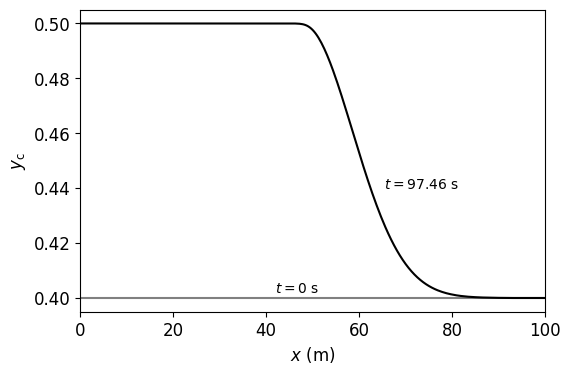

In [159]:
plt.figure(figsize=(6,4), dpi=100)
# plt.plot(SBC_fields_0x5.x, SBC_fields_0x5.yC[-1,:])
# plt.plot(SBC_fields_0x55.x, SBC_fields_0x55.yC[-1,:])
# plt.plot(SBC_fields_0000.x, SBC_fields_0000.yC[-1,:])
# plt.plot(SBC_fields_000.x, SBC_fields_000.yC[-1,:])
# plt.plot(SBC_fields_00.x, SBC_fields_00.yC[-1,:])
# plt.plot(SBC_fields_0.x, SBC_fields_0.yC[-1,:])
# plt.plot(SBC_fields_1.x, SBC_fields_1.yC[-1,:])
plt.plot(SBC_fields_2.x, SBC_fields_2.yC[0,:], '-', color="gray")

plt.plot(SBC_fields_2.x, SBC_fields_2.yC[-1,:], 'k-')
# plt.plot(SBC_fields_3.x, SBC_fields_3.yC[-1,:], 'k-')
plt.xlim(0, 100)
plt.xlabel("$x$ (m)")
plt.ylabel(r"$y_\mathrm{c}$")

global_fontsize = 12
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(global_fontsize)

plt.text(SBC_fields_2.x[200], SBC_fields_2.yC[-1,200], f"   $t = {SBC_fields_1.t[-1]:.2f}$ s")
plt.text(SBC_fields_2.x[125], SBC_fields_2.yC[0,125]+.002, f"   $t = 0$ s")

# plt.legend(["0x5", "0000", "000", "00", "0", "1", "2", "3"])

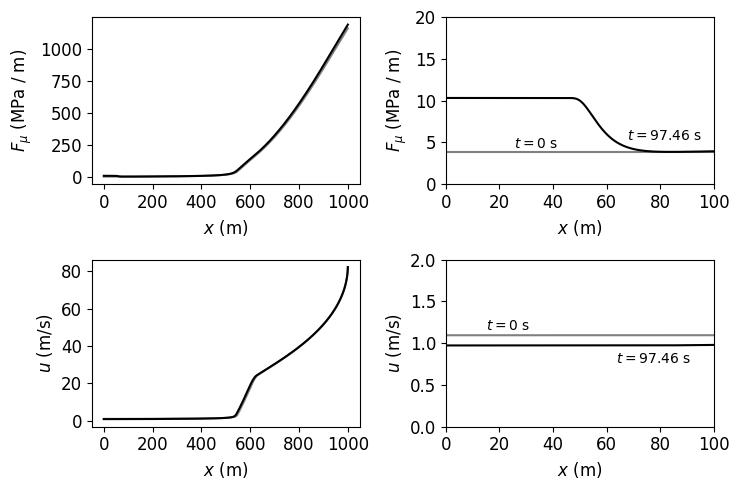

In [160]:
def get_vol_fric(fields:object, time_index=-1):
  ''' Compute volumetric friction term'''
  return split_solver.F_fric_viscosity_model(split_solver.T0,
    fields.yWv[time_index,:],
    fields.yF[time_index,:],
    fields.yWt[time_index,:],
    fields.yC[time_index,:])
# F_mu0000 = get_vol_fric(SBC_fields_0000)

fig, axes = plt.subplots(2, 2, figsize=(7.5,5), dpi=100)

''' Panel (1,1) '''

plt.sca(axes[0,0])
plt.plot(SBC_fields_2.x, get_vol_fric(SBC_fields_2, 0) / 1e6, color="gray")
plt.plot(SBC_fields_2.x, get_vol_fric(SBC_fields_2, -1) / 1e6, 'k-')
# plt.xlim(0, 100)
# plt.ylim(0, 0.2e2)
plt.xlabel("$x$ (m)")
plt.ylabel(r"$F_\mu$ (MPa / m)")
# plt.title(f"$t = {SBC_fields_1.t[-1]:.2f}$ s")

global_fontsize = 12
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(global_fontsize)
# plt.text(SBC_fields_2.x[200], get_vol_fric(SBC_fields_2, -1)[200] / 1e6, f"   $t = {SBC_fields_1.t[-1]:.2f}$ s")
# plt.text(SBC_fields_2.x[125], get_vol_fric(SBC_fields_2, 0)[125] / 1e6 + .3, f"   $t = 0$ s")

from matplotlib.patches import Rectangle
# plt.gca().add_patch(Rectangle((0, 0), 100, 0.2e2,
                              # fill=None, alpha=1))


''' Panel (1,2) '''

plt.sca(axes[0,1])
plt.plot(SBC_fields_2.x, get_vol_fric(SBC_fields_2, 0) / 1e6, color="gray")
plt.plot(SBC_fields_2.x, get_vol_fric(SBC_fields_2, -1) / 1e6, 'k-')
plt.xlim(0, 100)
plt.ylim(0, 0.2e2)
plt.xlabel("$x$ (m)")
plt.ylabel(r"$F_\mu$ (MPa / m)")
# plt.title(f"$t = {SBC_fields_1.t[-1]:.2f}$ s")

global_fontsize = 12
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(global_fontsize)
plt.text(SBC_fields_2.x[200], get_vol_fric(SBC_fields_2, -1)[200] / 1e6, f"   $t = {SBC_fields_1.t[-1]:.2f}$ s")
plt.text(SBC_fields_2.x[66], get_vol_fric(SBC_fields_2, 0)[66] / 1e6 + .45, f"   $t = 0$ s")

''' Panel (2,1) '''

plt.sca(axes[1,0])
plt.plot(SBC_fields_2.x, SBC_fields_2.u[0,:], color="gray")
plt.plot(SBC_fields_2.x, SBC_fields_2.u[-1,:], 'k-')
# plt.xlim(0, 100)
# plt.ylim(0, 2)
plt.xlabel("$x$ (m)")
plt.ylabel(r"$u$ (m/s)")
# plt.title(f"$t = {SBC_fields_1.t[-1]:.2f}$ s")

global_fontsize = 12
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(global_fontsize)
# plt.text(SBC_fields_2.x[188], SBC_fields_2.u[0,188] - 0.33, f"   $t = {SBC_fields_1.t[-1]:.2f}$ s")
# plt.text(SBC_fields_2.x[32], SBC_fields_2.u[-1,32] + 0.18, f"   $t = 0$ s")

''' Panel (2,2) '''

plt.sca(axes[1,1])
plt.plot(SBC_fields_2.x, SBC_fields_2.u[0,:], color="gray")
plt.plot(SBC_fields_2.x, SBC_fields_2.u[-1,:], 'k-')
plt.xlim(0, 100)
plt.ylim(0, 2)
plt.xlabel("$x$ (m)")
plt.ylabel(r"$u$ (m/s)")
# plt.title(f"$t = {SBC_fields_1.t[-1]:.2f}$ s")

global_fontsize = 12
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(global_fontsize)
plt.text(SBC_fields_2.x[188], SBC_fields_2.u[0,188] - 0.33, f"   $t = {SBC_fields_1.t[-1]:.2f}$ s")
plt.text(SBC_fields_2.x[32], SBC_fields_2.u[-1,32] + 0.18, f"   $t = 0$ s")

fig.tight_layout()

In [69]:
dt_vec = [SBC_fields_0x5.t[1] - SBC_fields_0x5.t[0],
  SBC_fields_0x55.t[1] - SBC_fields_0x55.t[0],
  SBC_fields_0000.t[1] - SBC_fields_0000.t[0],
  SBC_fields_000.t[1] - SBC_fields_000.t[0],
  SBC_fields_00.t[1] - SBC_fields_00.t[0],
  SBC_fields_0.t[1] - SBC_fields_0.t[0]]
dt_vec = np.array(dt_vec)

In [74]:
dx = SBC_fields_0.x[1] - SBC_fields_0.x[0]

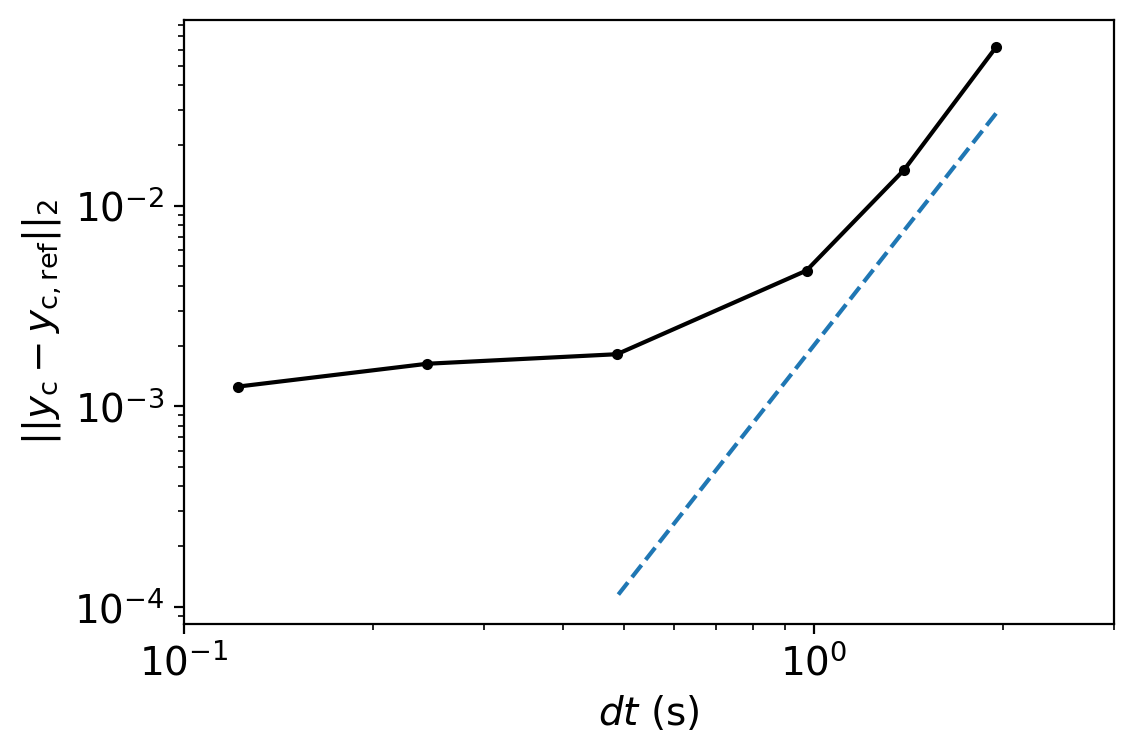

In [161]:
plt.figure(figsize=(6,4), dpi=200)
e0x5 = SBC_fields_0x5.yC[-1,:] - SBC_fields_3.yC[-1,:]
e0x55 = SBC_fields_0x55.yC[-1,:] - SBC_fields_3.yC[-1,:]
e0000 = SBC_fields_0000.yC[-1,:] - SBC_fields_3.yC[-1,:]
e000 = SBC_fields_000.yC[-1,:] - SBC_fields_3.yC[-1,:]
e00 = SBC_fields_00.yC[-1,:] - SBC_fields_3.yC[-1,:]
e0 = SBC_fields_0.yC[-1,:] - SBC_fields_3.yC[-1,:]
# e3 = SBC_fields_00.yC[-1,:] - SBC_fields_3.yC[-1,:]

# plt.plot(SBC_fields_00.x, e00)
# plt.plot(SBC_fields_0.x, e0)
# plt.plot(SBC_fields_1.x, e1)
# plt.plot(SBC_fields_2.x, e2)
# plt.legend([-1, 0, 1, 2])

e_vec = [(e0x5 * e0x5).sum(), 
 (e0x55 * e0x55).sum(),
 (e0000 * e0000).sum(),
 (e000 * e000).sum(),
 (e00 * e00).sum(),
 (e0 * e0).sum(),
 ]
e_vecL2 = np.sqrt(dx * np.array(e_vec))

plt.loglog(dt_vec, e_vecL2, 'k.-')
plt.loglog(dt_vec[:-2], 2e-3*dt_vec[:-2]**4, '--')

plt.xlim(1e-1, 3e0)
plt.xlabel("$dt$ (s)")
plt.ylabel(r"$||y_\mathrm{c} - y_{\mathrm{c},\mathrm{ref}}||_2$")
# plt.title(f"$t = {SBC_fields_1.t[-1]:.2f}$ s")

global_fontsize = 14
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(global_fontsize)

# plt.legend(["0x5", "0000", "000", "00", "0", "1", "2", "3"])